In [1]:
import tensorflow as tf
import os
import SimpleITK as sitk
import numpy as np
from tqdm.notebook import tqdm
import random
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
train_path = r"D:\Personal Project\Federated-Anatomy-Prediction\data\data-science-bowl-2018\stage1_train"
test_path = r"D:\Personal Project\Federated-Anatomy-Prediction\data\data-science-bowl-2018\stage1_test"

In [4]:
img_width = 256
img_height = 256
img_channels = 3

In [5]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [31]:
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool_)

X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)

In [32]:
inputs = tf.keras.layers.Input((img_width, img_height, img_channels))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

In [37]:
for i, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(train_path, id_)
    img = imread(path + "\images\\" + id_ + ".png")[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode="constant", preserve_range=True)
    X_train[i] = img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + "\masks"))[2]:
        mask_ = imread(path + "\masks\\" + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode="constant", preserve_range=True), axis=-1)

        mask = np.maximum(mask, mask_)
    
    Y_train[i] = mask

100%|██████████| 670/670 [05:14<00:00,  2.13it/s]


In [36]:
for i, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(test_path, id_)
    img = imread(path + "\images\\" + id_ + ".png")[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode="constant", preserve_range=True)
    X_test[i] = img

100%|██████████| 65/65 [00:02<00:00, 29.95it/s]


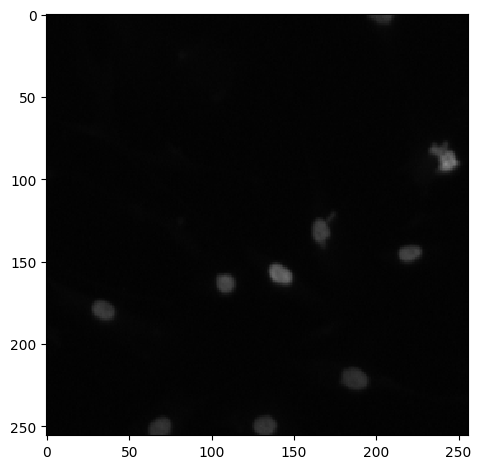

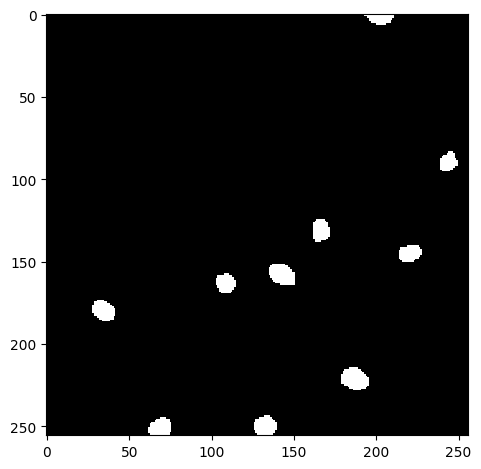

In [39]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [40]:
#Encoder
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
p5 = tf.keras.layers.MaxPool2D((2,2))(c5)

In [41]:
#Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal",    padding="same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

In [42]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ lambda_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_for_segmentation.h5",
    verbose=1,
    save_best_only=True
)

In [44]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3
    ),

    tf.keras.callbacks.TensorBoard(
        log_dir="logs"
    )
]

In [65]:
result = model.fit(x=X_train, y=Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8416 - loss: 0.4014 - val_accuracy: 0.8649 - val_loss: 0.2537
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8637 - loss: 0.2446 - val_accuracy: 0.9434 - val_loss: 0.1518
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9397 - loss: 0.1706 - val_accuracy: 0.9509 - val_loss: 0.1217
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9511 - loss: 0.1292 - val_accuracy: 0.9560 - val_loss: 0.1164
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9596 - loss: 0.1048 - val_accuracy: 0.9623 - val_loss: 0.0981
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9603 - loss: 0.1023 - val_accuracy: 0.9645 - val_loss: 0.0916
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9603 - loss: 0.1008 - val_accuracy: 0.9650 - val_loss: 0.0889
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9639 - loss: 0.0922 - val_accuracy: 0.9640 - val_loss:

In [68]:
idx = random.randint(0, len(train_ids))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #divide the train into 90% train and 10% validate (90% train) (from the start to 90% of the images)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #10% validate
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


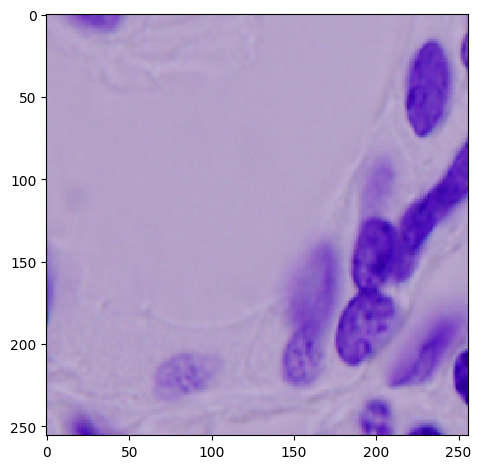

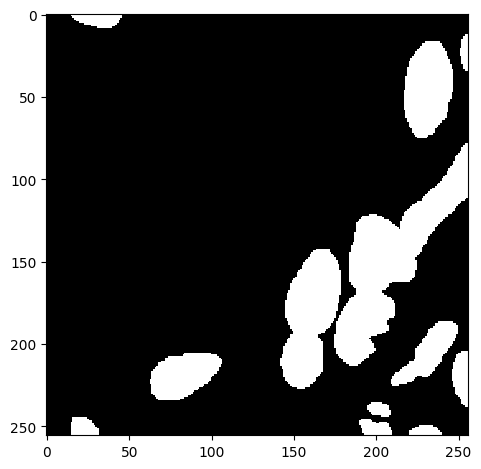

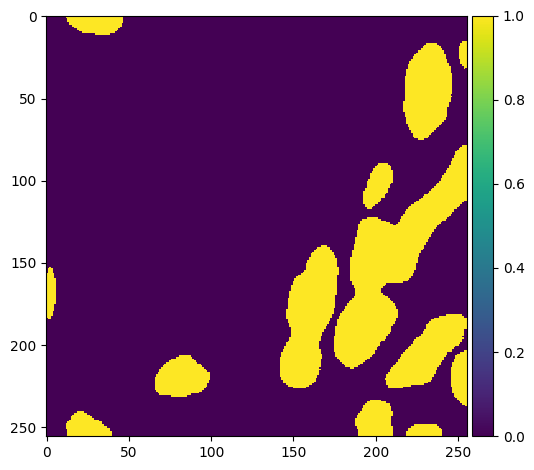

In [69]:
imshow(X_train[idx])
plt.show()
imshow(np.squeeze(Y_train[idx]))
plt.show()
imshow(preds_train_t[idx])
plt.show()

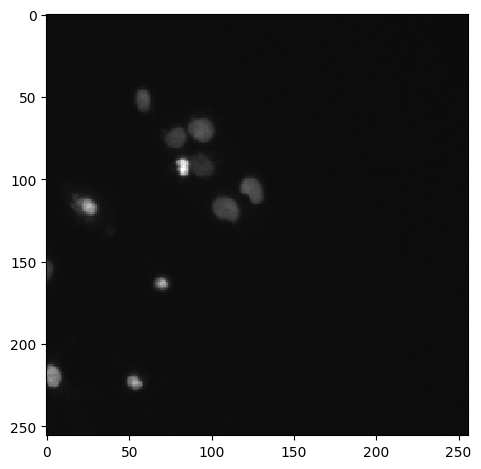

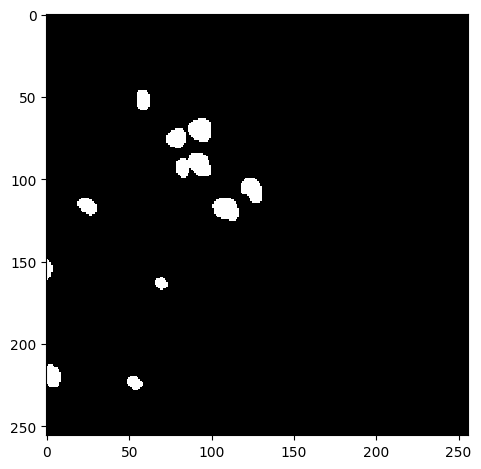

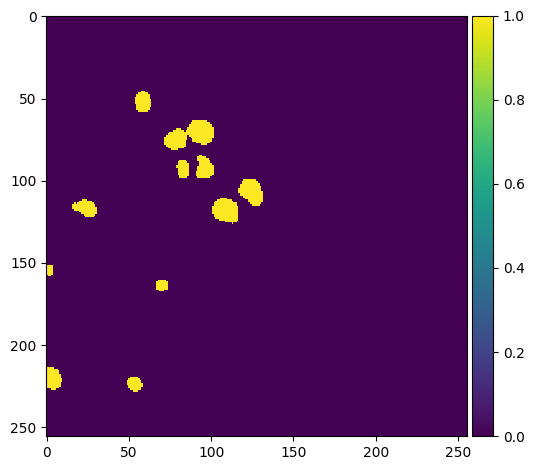

In [81]:
idx = random.randint(0, len(preds_test_t))
imshow(X_train[int(X_train.shape[0]*0.9):][idx])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][idx]))
plt.show()
imshow(np.squeeze(preds_val_t[idx]))
plt.show()